In [58]:
!rm -rf pytorch_utils
!git clone https://github.com/rahuldsce/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 43 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (43/43), 17.13 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [59]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [60]:
import torch.nn as nn
import torch.nn.functional as F

In [64]:
from pytorch_utils import dataset, model
train, test = dataset.cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [65]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [67]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar10_model = model.Cifar10_LN().to(device)
summary(cifar10_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         LayerNorm-3           [-1, 16, 32, 32]          32,768
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         LayerNorm-7           [-1, 32, 32, 32]          65,536
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             512
           Conv2d-11           [-1, 16, 16, 16]           2,304
             ReLU-12           [-1, 16, 16, 16]               0
        LayerNorm-13           [-1, 16, 16, 16]           8,192
          Dropout-14           [-1, 16,

In [68]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [69]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.SGD(cifar10_model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(cifar10_model, device, train_loader, optimizer, epoch)
    test(cifar10_model, device, test_loader)

EPOCH: 0


Loss=1.6464735269546509 Batch_id=390 Accuracy=27.84: 100%|██████████| 391/391 [00:32<00:00, 12.02it/s]



Test set: Average loss: 1.7612, Accuracy: 3472/10000 (34.72%)

EPOCH: 1


Loss=1.6178529262542725 Batch_id=390 Accuracy=37.21: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]



Test set: Average loss: 1.5896, Accuracy: 4139/10000 (41.39%)

EPOCH: 2


Loss=1.4959824085235596 Batch_id=390 Accuracy=43.57: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]



Test set: Average loss: 1.5203, Accuracy: 4464/10000 (44.64%)

EPOCH: 3


Loss=1.3774733543395996 Batch_id=390 Accuracy=49.34: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]



Test set: Average loss: 1.2818, Accuracy: 5359/10000 (53.59%)

EPOCH: 4


Loss=1.262516736984253 Batch_id=390 Accuracy=53.53: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]



Test set: Average loss: 1.2219, Accuracy: 5538/10000 (55.38%)

EPOCH: 5


Loss=1.164382815361023 Batch_id=390 Accuracy=56.73: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]



Test set: Average loss: 1.1480, Accuracy: 5887/10000 (58.87%)

EPOCH: 6


Loss=1.235074520111084 Batch_id=390 Accuracy=59.08: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]



Test set: Average loss: 1.0973, Accuracy: 6109/10000 (61.09%)

EPOCH: 7


Loss=1.2096179723739624 Batch_id=390 Accuracy=61.15: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]



Test set: Average loss: 1.0396, Accuracy: 6396/10000 (63.96%)

EPOCH: 8


Loss=1.0207276344299316 Batch_id=390 Accuracy=62.88: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]



Test set: Average loss: 0.9733, Accuracy: 6534/10000 (65.34%)

EPOCH: 9


Loss=1.1031497716903687 Batch_id=390 Accuracy=64.30: 100%|██████████| 391/391 [00:27<00:00, 14.43it/s]



Test set: Average loss: 0.9647, Accuracy: 6540/10000 (65.40%)

EPOCH: 10


Loss=0.9825423359870911 Batch_id=390 Accuracy=65.60: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]



Test set: Average loss: 0.9381, Accuracy: 6724/10000 (67.24%)

EPOCH: 11


Loss=1.476780891418457 Batch_id=390 Accuracy=66.69: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]



Test set: Average loss: 0.9202, Accuracy: 6736/10000 (67.36%)

EPOCH: 12


Loss=0.7730557918548584 Batch_id=390 Accuracy=67.82: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]



Test set: Average loss: 0.8961, Accuracy: 6857/10000 (68.57%)

EPOCH: 13


Loss=0.8886672258377075 Batch_id=390 Accuracy=68.39: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]



Test set: Average loss: 0.8977, Accuracy: 6834/10000 (68.34%)

EPOCH: 14


Loss=0.7960505485534668 Batch_id=390 Accuracy=68.91: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]



Test set: Average loss: 0.8403, Accuracy: 7059/10000 (70.59%)

EPOCH: 15


Loss=0.7246102094650269 Batch_id=390 Accuracy=69.79: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]



Test set: Average loss: 0.8434, Accuracy: 7062/10000 (70.62%)

EPOCH: 16


Loss=0.8069467544555664 Batch_id=390 Accuracy=70.67: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]



Test set: Average loss: 0.8235, Accuracy: 7160/10000 (71.60%)

EPOCH: 17


Loss=0.8028321266174316 Batch_id=390 Accuracy=71.06: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]



Test set: Average loss: 0.8053, Accuracy: 7181/10000 (71.81%)

EPOCH: 18


Loss=0.8957668542861938 Batch_id=390 Accuracy=71.71: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]



Test set: Average loss: 0.7695, Accuracy: 7285/10000 (72.85%)

EPOCH: 19


Loss=0.6172940731048584 Batch_id=390 Accuracy=72.46: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]



Test set: Average loss: 0.7404, Accuracy: 7398/10000 (73.98%)



In [55]:
torch.save(model.state_dict(), f"./cifar_10_ln.pth")

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_misclassified_images_from_model(model, model_path, data_loader, class_labels, image_count):
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  correct = 0
  figure = plt.figure(figsize=(15,15))
  count = 0
  with torch.no_grad():
      for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          for idx in range(len(pred)):
            i_pred, i_act = pred[idx], target[idx]
            if i_pred != i_act:
                annotation = "Actual: %s, Predicted: %s" % (class_labels[i_act], class_labels[i_pred])
                count += 1
                plt.subplot(5, 2, count)
                plt.axis('off')
                imshow(data[idx].cpu())
                plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=13)
            if count == image_count:
                return

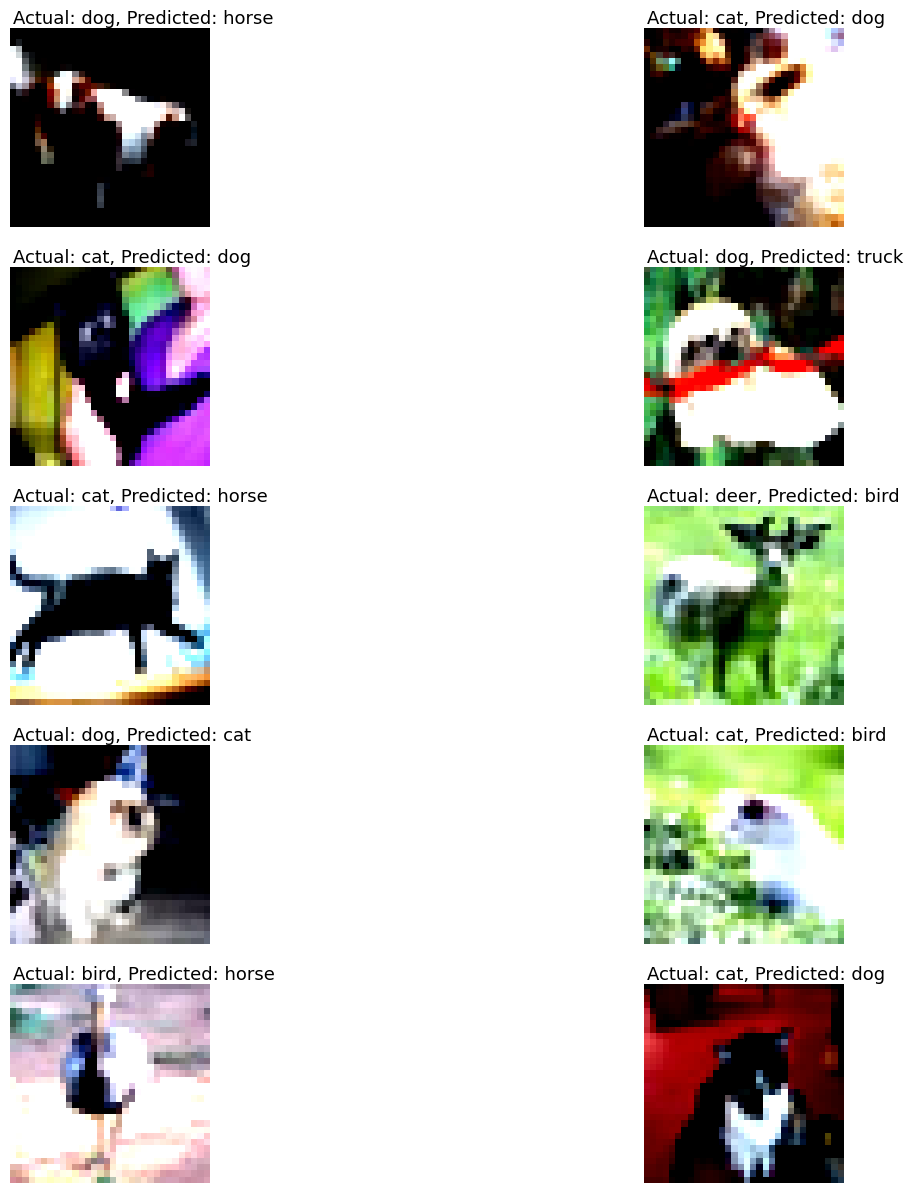

In [57]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_misclassified_images_from_model(model, "./cifar_10_ln.pth", test_loader, classes, 10)